<a href="https://colab.research.google.com/github/SJKIM2253/Statistics_with_Python/blob/master/190719_%EC%8B%9C%EA%B3%84%EC%97%B4_%EB%B6%84%EC%84%9D_%EC%8B%A4%EC%8A%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from statsmodels.formula.api import ols
from statsmodels.api import qqplot, add_constant
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tools.eval_measures import rmse  # 추정의 표준오차
%matplotlib inline

from sklearn.tree import export_graphviz
import graphviz

from sklearn.neighbors import KNeighborsRegressor as KNR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV   # cross validation(구버전)

In [3]:
df_raw=pd.read_csv("/content/drive/My Drive/BigDataAnalysis/환율.csv", parse_dates = ["APPL_DATE"], engine="python")
df_raw.head()

,CURRENCY,APPL_DATE,STD_RATE,USD_CONV_DATE
0,CNY,2016-01-01,181.48,0.1541
1,JPY,2016-01-01,976.99,0.8294
2,USD,2016-01-01,1178.00,1.0000
3,CNY,2016-01-02,181.48,0.1541
4,JPY,2016-01-02,976.99,0.8294


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


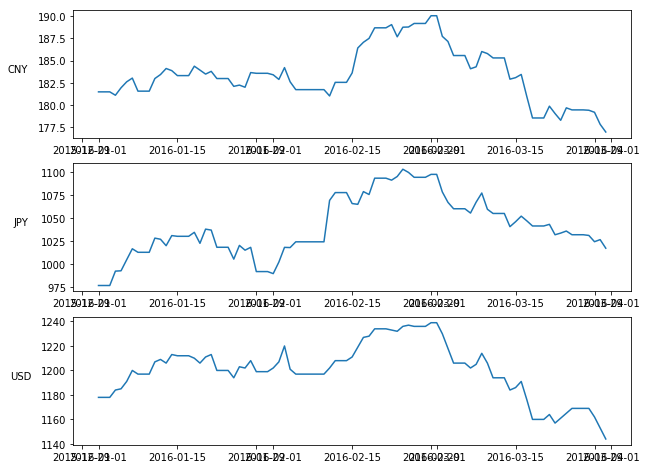

In [4]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows = 3, ncols = 1, figsize = (10,8))
for(ax, idx, currency) in zip([ax1, ax2, ax3], [311,312,313],["CNY","JPY","USD"]):
    ax.plot("APPL_DATE","STD_RATE", data = df_raw[df_raw["CURRENCY"]==currency])
    ax.set_ylabel(currency, rotation=0, labelpad = 20)

In [5]:
df_CNY = df_raw[df_raw["CURRENCY"]=="CNY"].set_index("APPL_DATE")
df_CNY.drop(["CURRENCY","USD_CONV_DATE"], axis=1, inplace = True)

df_JPY = df_raw[df_raw["CURRENCY"]=="JPY"].set_index("APPL_DATE")
df_JPY.drop(["CURRENCY","USD_CONV_DATE"], axis=1, inplace = True)

df_USD = df_raw[df_raw["CURRENCY"]=="JPY"].set_index("APPL_DATE")
df_USD.drop(["CURRENCY","USD_CONV_DATE"], axis=1, inplace = True)
df_CNY.head()

,STD_RATE
APPL_DATE,
2016-01-01,181.48
2016-01-02,181.48
2016-01-03,181.48
2016-01-04,181.10
2016-01-05,181.94


In [6]:
train_size = 0.9
len_idx = len(df_CNY.index)
mask = (np.arange(len_idx)/len_idx) < train_size
mask

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False, False, False, False, False, False, False, False,
       False])

In [7]:
df_CNY_train = df_CNY[mask]
df_CNY_test = df_CNY[~mask]
print("shape of train data: {}".format(df_CNY_train.shape))
print("shape of test data: {}".format(df_CNY_test.shape))

shape of train data: (82, 1)
shape of test data: (9, 1)


In [8]:
df_CNY_train = df_CNY[df_CNY.index <= "2016-03-22"]
df_CNY_test = df_CNY[df_CNY.index > "2016-03-22"]

df_CNY_test.head()

,STD_RATE
APPL_DATE,
2016-03-23,178.28
2016-03-24,179.68
2016-03-25,179.45
2016-03-26,179.45
2016-03-27,179.45


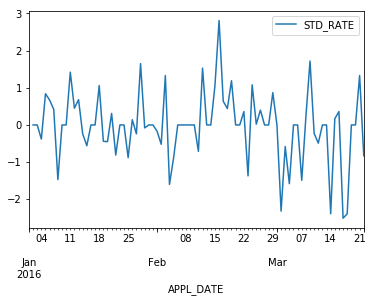

In [9]:
df_CNY_diff1 = df_CNY_train - df_CNY_train.shift(1)
df_CNY_diff1.plot()

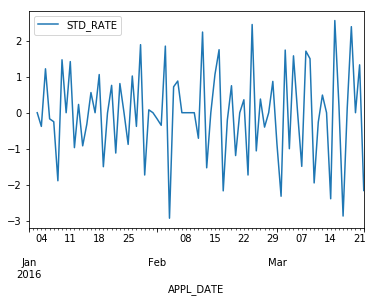

In [10]:
df_CNY_diff2 = df_CNY_train - 2*(df_CNY_train.shift(1)) + (df_CNY_train.shift(2))
df_CNY_diff2.plot()

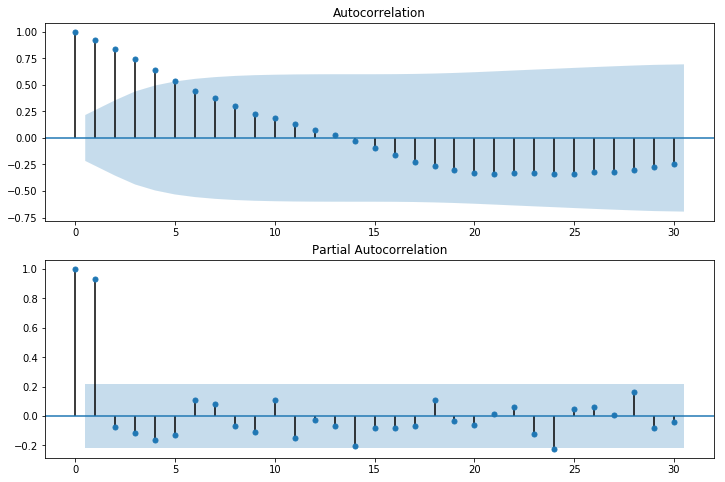

In [11]:
lag_size = 30
fig=plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig=plot_acf(df_CNY_train["STD_RATE"], lags=lag_size, ax=ax1)
ax2=fig.add_subplot(212)
fig=plot_pacf(df_CNY_train["STD_RATE"], lags=lag_size, ax=ax2)

In [12]:
ts_model_cny=ARIMA(df_CNY_train, order=(1,2,0))
ts_result_cny = ts_model_cny.fit(trend = "c", full_output = True)
print(ts_result_cny.summary())

                             ARIMA Model Results                              
Dep. Variable:            D2.STD_RATE   No. Observations:                   80
Model:                 ARIMA(1, 2, 0)   Log Likelihood                -123.512
Method:                       css-mle   S.D. of innovations              1.132
Date:                Fri, 19 Jul 2019   AIC                            253.025
Time:                        07:05:34   BIC                            260.171
Sample:                    01-03-2016   HQIC                           255.890
                         - 03-22-2016                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.0022      0.088     -0.024      0.981      -0.175       0.171
ar.L1.D2.STD_RATE    -0.4389      0.102     -4.322      0.000      -0.638      -0.240
                        

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


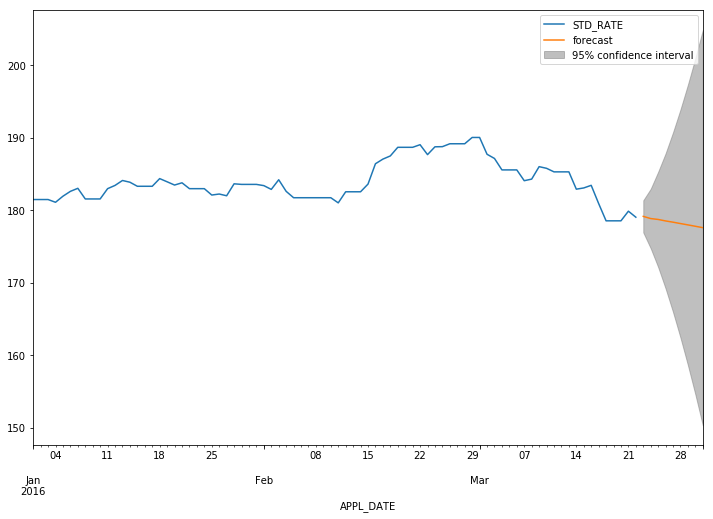

In [13]:
start_time = df_CNY_test.index.min()
end_time = df_CNY_test.index.max()
fig, ax = plt.subplots(figsize = (12,8))
ax = df_CNY_train.plot(ax =ax)
fig=ts_result_cny.plot_predict(start=start_time, end=end_time, ax=ax, plot_insample = False)

In [14]:
start_time = pd.to_datetime("2016-01-03")
y_pred = ts_result_cny.predict(start=start_time, end=end_time, typ = 'levels')
df_merge = df_CNY
df_merge["예측값"]=y_pred
df_merge.head()

,STD_RATE,예측값
APPL_DATE,,
2016-01-01,181.48,NaN
2016-01-02,181.48,NaN
2016-01-03,181.48,181.477844
2016-01-04,181.10,181.476897
2016-01-05,181.94,180.883667


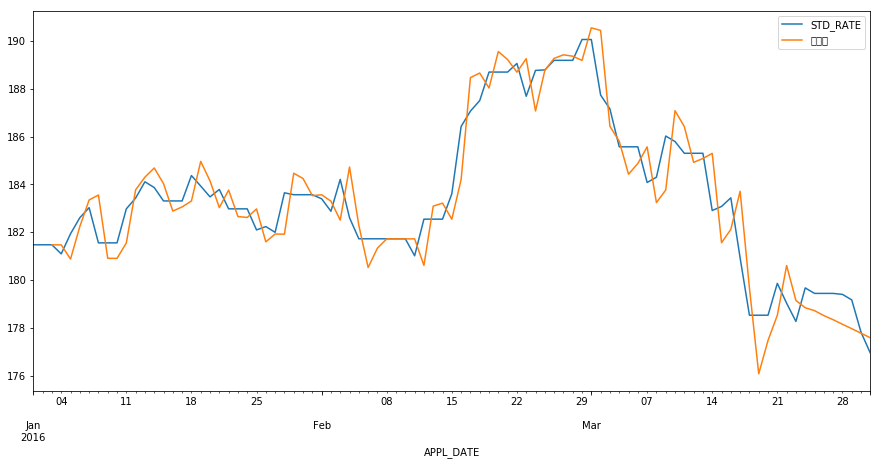

In [15]:
df_merge.plot(y=["STD_RATE","예측값"],figsize = (15,7))

In [20]:
train_size = 0.9
len_idx = len(df_USD.index)
mask = (np.arange(len_idx)/len_idx) < train_size
mask

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False, False, False, False, False, False, False, False,
       False])

In [21]:
df_USD_train = df_USD[mask]
df_USD_test = df_USD[~mask]
print("shape of train data: {}".format(df_USD_train.shape))
print("shape of test data: {}".format(df_USD_test.shape))

shape of train data: (82, 1)
shape of test data: (9, 1)


In [22]:
df_USD_train = df_USD[df_USD.index <= "2016-03-22"]
df_USD_test = df_USD[df_USD.index > "2016-03-22"]

df_USD_test.head()

,STD_RATE
APPL_DATE,
2016-03-23,1034.02
2016-03-24,1036.25
2016-03-25,1032.23
2016-03-26,1032.23
2016-03-27,1032.23


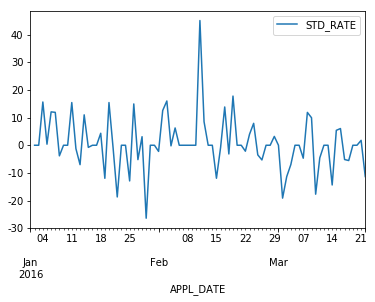

In [23]:
df_USD_diff1 = df_USD_train - df_USD_train.shift(1)
df_USD_diff1.plot()

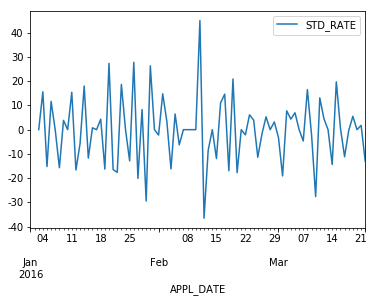

In [24]:
df_USD_diff2 = df_USD_train - 2*(df_USD_train.shift(1)) + (df_USD_train.shift(2))
df_USD_diff2.plot()

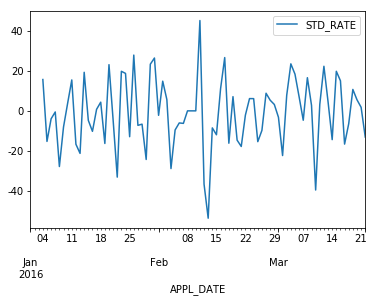

In [35]:
df_USD_diff3 = df_USD_train - 2*(df_USD_train.shift(1)) + (df_USD_train.shift(3))
df_USD_diff3.plot()

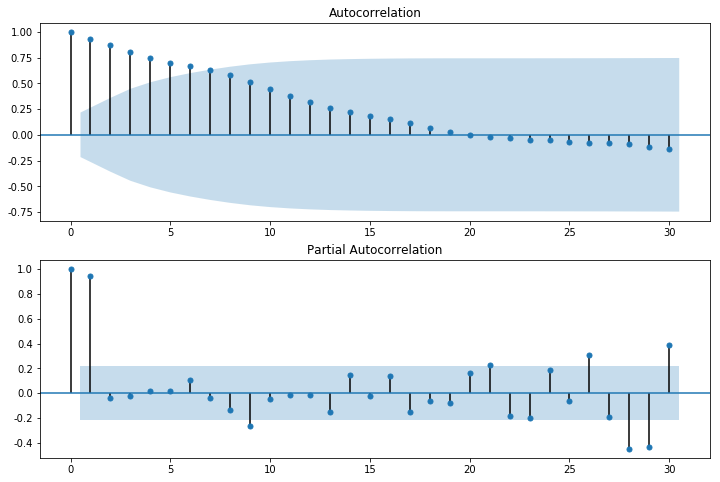

In [36]:
lag_size = 30
fig=plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig=plot_acf(df_USD_train["STD_RATE"], lags=lag_size, ax=ax1)
ax2=fig.add_subplot(212)
fig=plot_pacf(df_USD_train["STD_RATE"], lags=lag_size, ax=ax2)

In [37]:
ts_model_cny=ARIMA(df_USD_train, order=(1,2,0))
ts_result_cny = ts_model_cny.fit(trend = "c", full_output = True)
print(ts_result_cny.summary())

                             ARIMA Model Results                              
Dep. Variable:            D2.STD_RATE   No. Observations:                   80
Model:                 ARIMA(1, 2, 0)   Log Likelihood                -313.420
Method:                       css-mle   S.D. of innovations             12.149
Date:                Fri, 19 Jul 2019   AIC                            632.841
Time:                        07:19:27   BIC                            639.987
Sample:                    01-03-2016   HQIC                           635.706
                         - 03-22-2016                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.0896      0.925     -0.097      0.923      -1.903       1.724
ar.L1.D2.STD_RATE    -0.4739      0.098     -4.844      0.000      -0.666      -0.282
                        

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


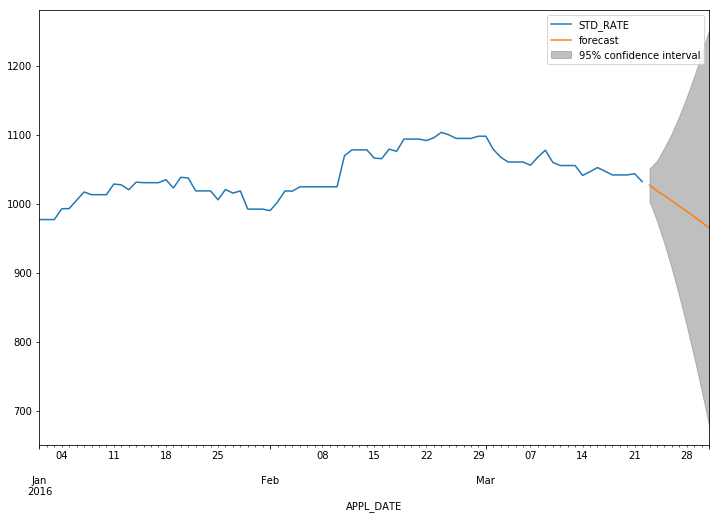

In [38]:
start_time = df_USD_test.index.min()
end_time = df_USD_test.index.max()
fig, ax = plt.subplots(figsize = (12,8))
ax = df_USD_train.plot(ax =ax)
fig=ts_result_cny.plot_predict(start=start_time, end=end_time, ax=ax, plot_insample = False)

In [39]:
start_time = pd.to_datetime("2016-01-03")
y_pred = ts_result_cny.predict(start=start_time, end=end_time, typ = 'levels')
df_merge = df_USD
df_merge["예측값"]=y_pred
df_merge.head()

,STD_RATE,예측값
APPL_DATE,,
2016-01-01,976.99,NaN
2016-01-02,976.99,NaN
2016-01-03,976.99,976.900395
2016-01-04,992.62,976.857926
2016-01-05,993.00,1000.710124


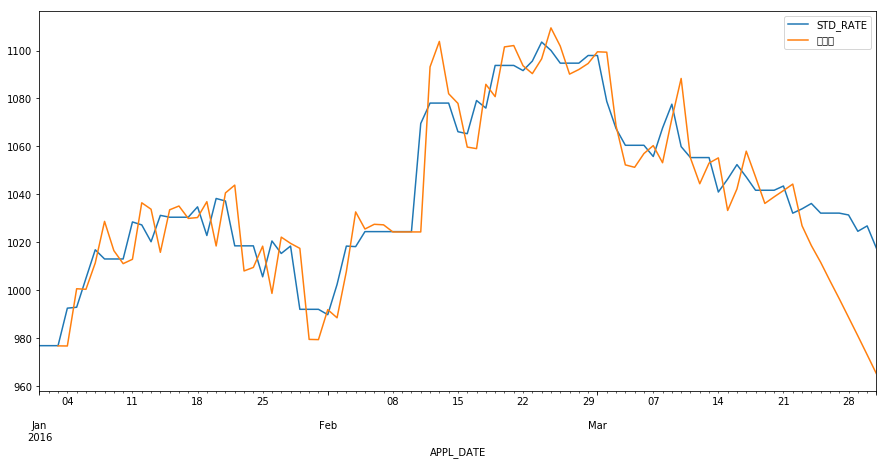

In [40]:
df_merge.plot(y=["STD_RATE","예측값"],figsize = (15,7))